In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
df_atm = pd.read_csv("train.csv")

In [3]:
df_atm.head()

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100


In [4]:
# cast the type of data
df_atm = df_atm.assign(past_years=df_atm.loc[:,"DATE"] \
                       .apply(lambda x : int(x.split('-')[0]) - 2014))
df_atm = df_atm.assign(month=df_atm.loc[:,"DATE"].apply(lambda x : x.split('-')[1]))
df_atm = df_atm.astype({'DATE': 'datetime64[ns]' , "month" : "int8"})
def mapQuarter(x):
    return (x -1) // 3 + 1
df_atm = df_atm.assign(Quarter=df_atm.loc[:,"month"].apply(lambda x : mapQuarter(x)))

In [5]:
df_atm.head()

,DATE,ATM_ID,CLIENT_OUT,past_years,month,Quarter
0,2015-01-01,0,91600,1,1,1
1,2015-01-02,0,136500,1,1,1
2,2015-01-03,0,335400,1,1,1
3,2015-01-04,0,379000,1,1,1
4,2015-01-05,0,344100,1,1,1


In [6]:
df_atm = df_atm.astype({'DATE': 'datetime64[ns]' , "month" : "int8"})

In [7]:
df_atm.dtypes

DATE          datetime64[ns]
ATM_ID                 int64
CLIENT_OUT             int64
past_years             int64
month                   int8
Quarter                int64
dtype: object

In [8]:
scaler=preprocessing.StandardScaler()
cols = ["past_years","ATM_ID","yearly_out"]
X_scaled = pd.DataFrame(scaler.fit_transform(df_atm["CLIENT_OUT"].values.reshape(-1, 1)),columns=["CLIENT_OUT_scaled"])
X_scaled = pd.concat((df_atm["Quarter"],df_atm["past_years"],df_atm["ATM_ID"],X_scaled),axis=1)

In [27]:
yearly_out = X_scaled.pivot_table(index = "ATM_ID", \
                                  columns = "Quarter",aggfunc = {"CLIENT_OUT_scaled" : [ np.min ]})

In [10]:
from sklearn.cluster import AgglomerativeClustering , KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [23]:
scores = []
inertia = []
for k in range(2,30):
    algo = KMeans(n_clusters=k).fit(yearly_out)
    labels = algo.labels_
    inertia.append(compute_distortion(algo,yearly_out))
    scores.append(silhouette_score(yearly_out,labels))

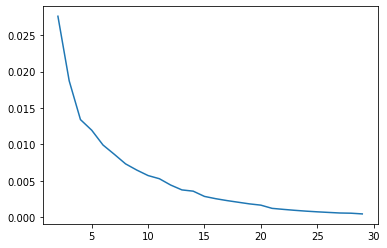

In [25]:
plt.plot(range(2,30),inertia)

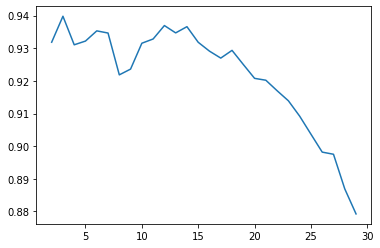

In [26]:
plt.plot(range(2,30),scores)

In [387]:
#scores = scores[3:]

In [388]:
np.argmax(scores) + 2

2

In [13]:
from scipy.spatial.distance import cdist

In [14]:
def compute_cluster_centres(model,data):
    centres = []
    labs = model.labels_
    for i in range(max(labs)+1):
        centres.append(np.mean(data.values[np.where(labs==i)[0]],axis=0))
    return centres

def compute_distortion(model,data):
    return sum(np.min(cdist(data, compute_cluster_centres(model,data), 'euclidean'), axis=1)) / data.shape[0]

In [15]:
opt_algo = AgglomerativeClustering(14)
opt_algo.fit(yearly_out)
labels = opt_algo.labels_
groups = {}
for i in range(max(labels)+1):
    groups["atm_cluster_" + str(i)] = yearly_out.reset_index()["ATM_ID"].values[np.where(labels==i)[0]]

In [17]:
def associate_cluster(x,groups):
    for c in list(groups):
        #print(c)
        if x in groups[c]:
            break
    return c

In [19]:
df_atm.loc[:,"atm_cluster"] = df_atm.loc[:,"ATM_ID"].apply(lambda x: associate_cluster(x,groups))

In [180]:
df_atm.groupby("atm_cluster").agg({"CLIENT_OUT" : "sum"})

,CLIENT_OUT
atm_cluster,
atm_cluster_0,105584525200


In [374]:
A.unique().shape

(13,)